In [1]:
from sklearn import model_selection
from sklearn import metrics
import scikitplot.metrics as skpm
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt


# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')
out_dir = os.path.join(data_dir, 'results/LogisticRegressionCV_PCA_Healthy_v_ACVD')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'SampleMetaDataClean.csv',
 'SampleMetaDataManual.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(2788, 38)

In [7]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(2788, 903)

In [8]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [9]:
X = MatrixData

In [10]:
y = SampleMeta['Healthy'].to_numpy().astype('str') == 'Healthy'
y = y.astype('int64')

# Define and Train Model

In [11]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

retrain = False
n_splits = 5
out_path = os.path.join(out_dir, 'MyMultiTrainTester.pk')

if retrain:
    # clear previous results, if any
    if os.path.exists(out_dir):
        os.system('rm -rf ' + out_dir)
    os.mkdir(out_dir)
    # random seed here deals with model initialization
    MyLogistic = LM.LogisticRegressionCV(random_state = 42, class_weight='balanced', Cs = np.exp(-np.arange(-10, 10)), 
                                         solver='saga', penalty='elasticnet', l1_ratios=np.arange(0, 1.10, 0.10),
                                        scoring=metrics.make_scorer(RECALL_SCORE))
    MyTrainer = Trainer(model = MyLogistic, scale_X = True, use_pca = True, n_components=100)
    # random seed used in class definition is not used in final output models
    MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE)
    # note that random seed here affects sequence of seeds passed to making new TrainTester objects
    # using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
    # across all data splits
    MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)
    MyMultiTrainTester.train(X, y)
    # save results
    outfile = open(out_path,'wb')
    pk.dump(MyMultiTrainTester, outfile)
    outfile.close()
    
else:
    # load previous results
    infile = open(out_path,'rb')
    MyMultiTrainTester = pk.load(infile)
    infile.close()
    


In [12]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.681000,train
1,0.717992,train
2,0.704208,train
3,0.725673,train
4,0.712405,train
0,0.677675,test
1,0.658904,test
2,0.693137,test
3,0.708070,test
4,0.664160,test


<AxesSubplot:xlabel='stage', ylabel='score'>

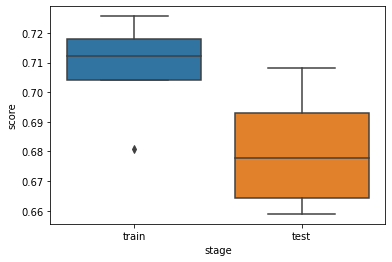

In [13]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [14]:
MyMultiTrainTester.TrainerList[0].model.Cs_

array([2.20264658e+04, 8.10308393e+03, 2.98095799e+03, 1.09663316e+03,
       4.03428793e+02, 1.48413159e+02, 5.45981500e+01, 2.00855369e+01,
       7.38905610e+00, 2.71828183e+00, 1.00000000e+00, 3.67879441e-01,
       1.35335283e-01, 4.97870684e-02, 1.83156389e-02, 6.73794700e-03,
       2.47875218e-03, 9.11881966e-04, 3.35462628e-04, 1.23409804e-04])

In [15]:
hyperparams = {'l1_ratio': [], 'C': []}
for i in range(n_splits):
    hyperparams['l1_ratio'].append(MyMultiTrainTester.TrainerList[i].model.l1_ratio_)
    hyperparams['C'].append(MyMultiTrainTester.TrainerList[i].model.C_)

In [16]:
pd.DataFrame(hyperparams)

,l1_ratio,C
0,[0.4],[0.006737946999085467]
1,[0.0],[0.006737946999085467]
2,[0.0],[0.006737946999085467]
3,[0.1],[0.0024787521766663585]
4,[0.0],[0.0009118819655545162]


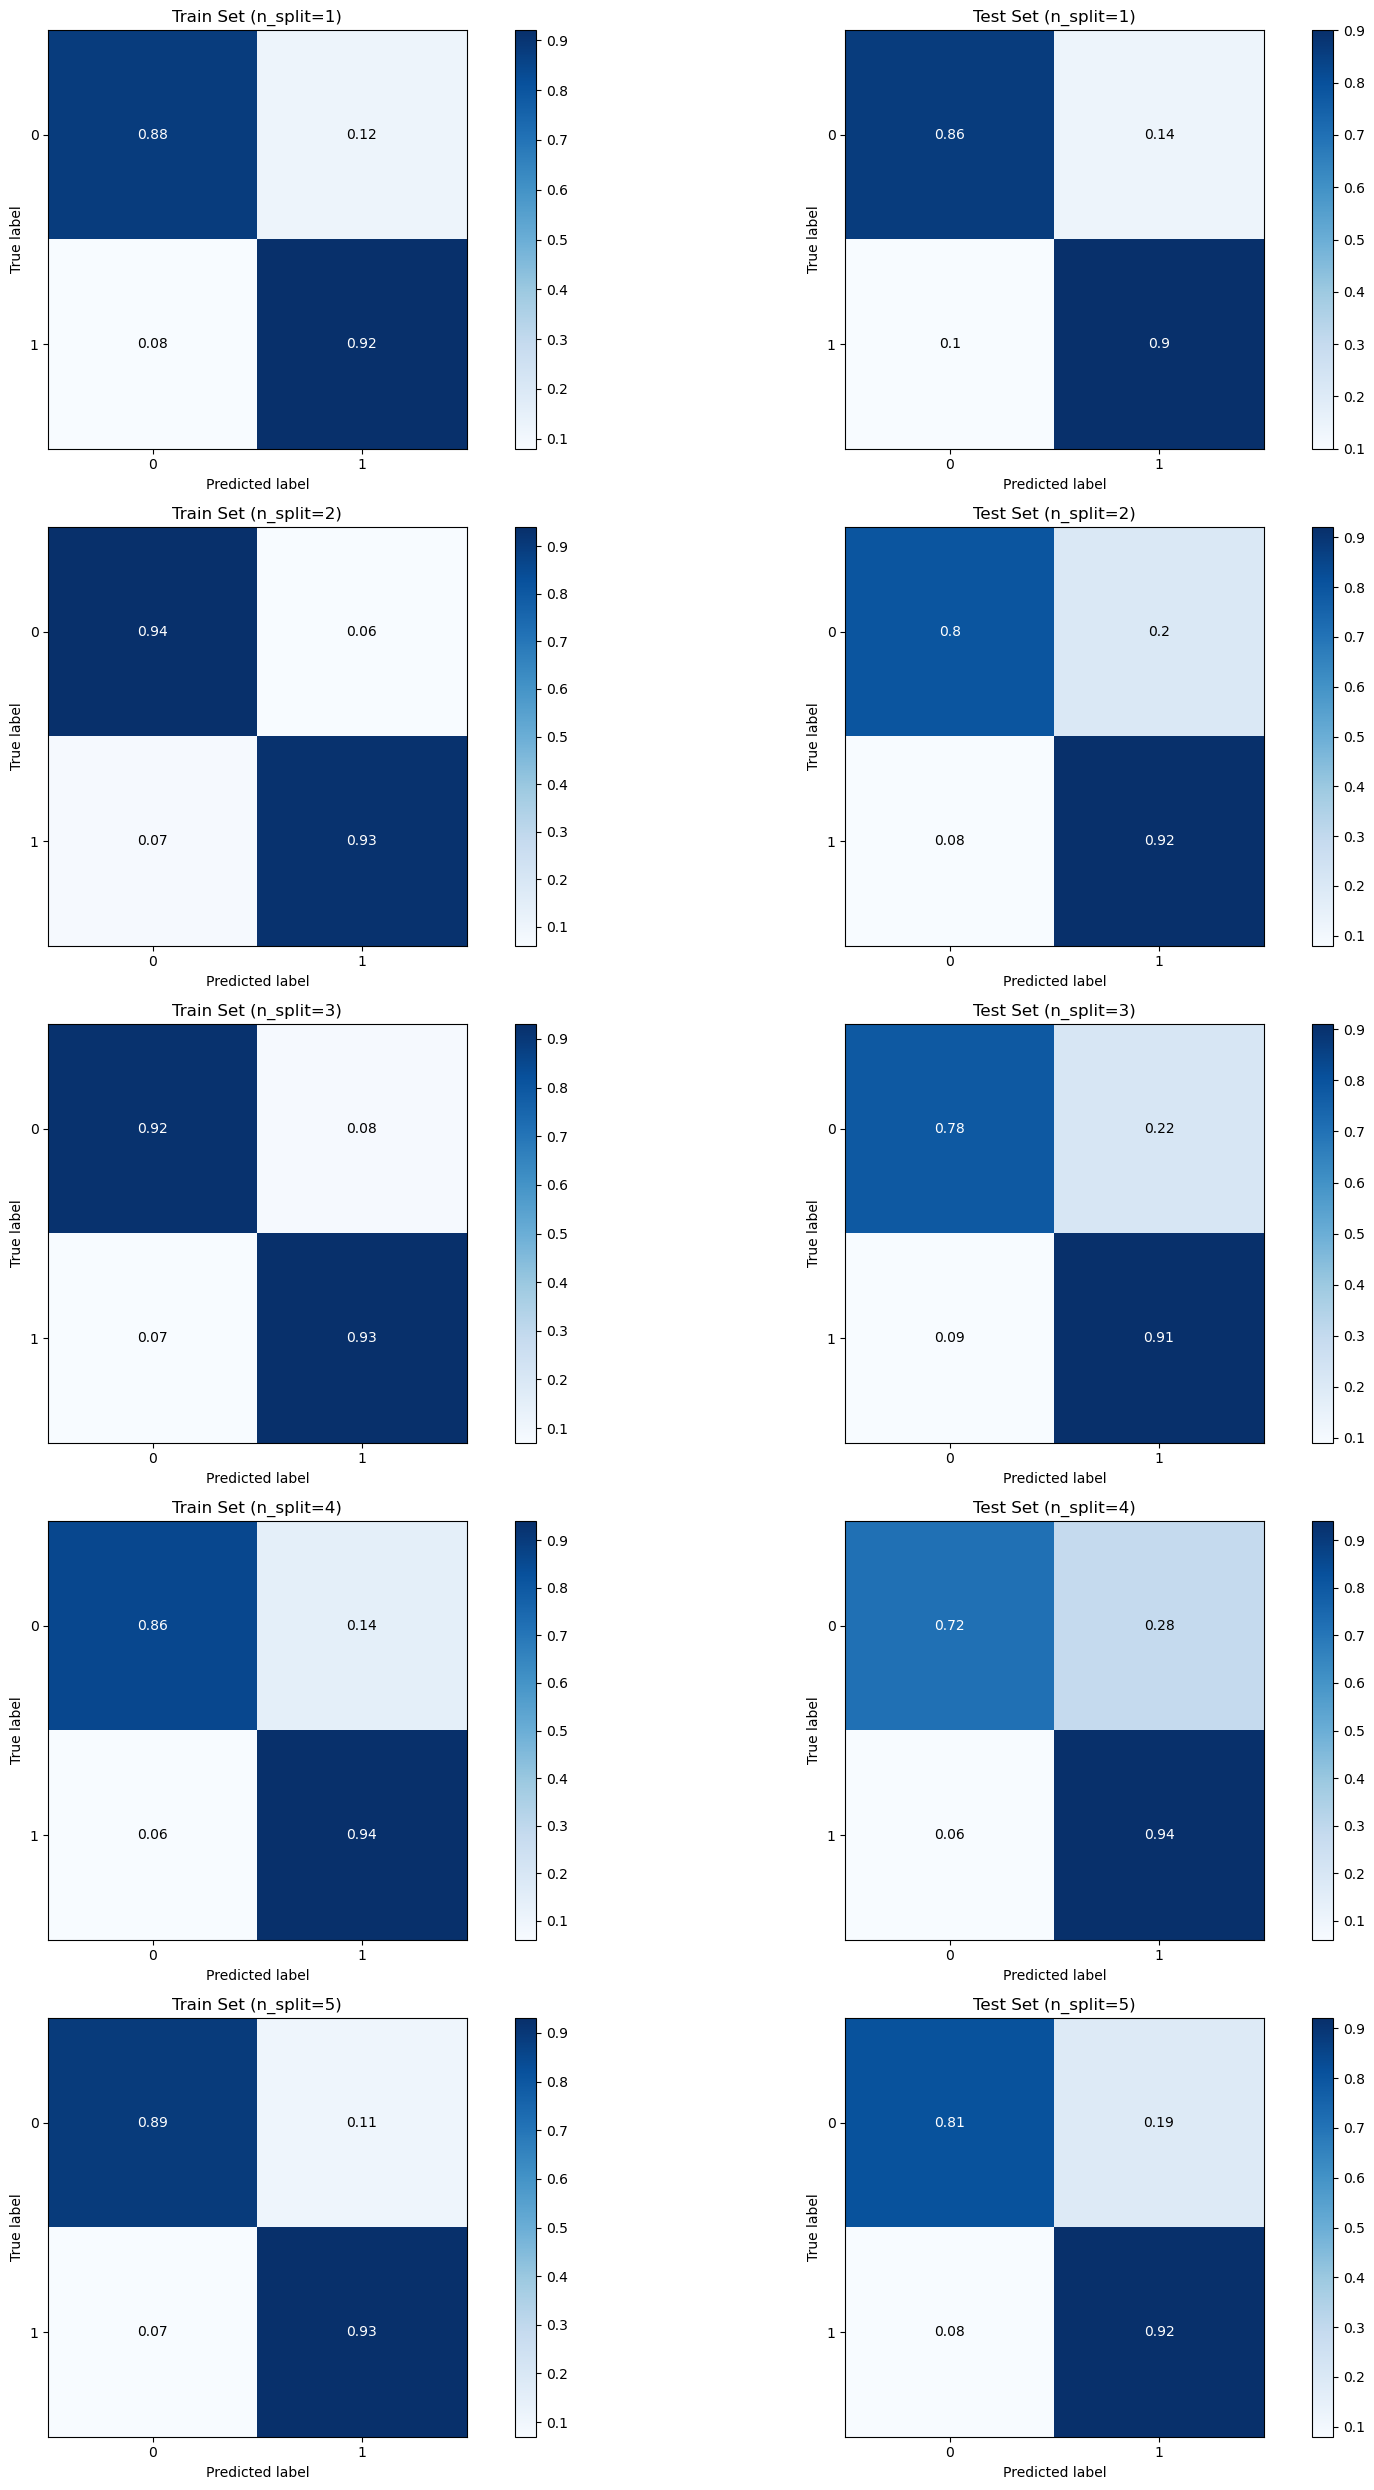

In [17]:
MyMultiTrainTester.plot_confusion(normalize=True)

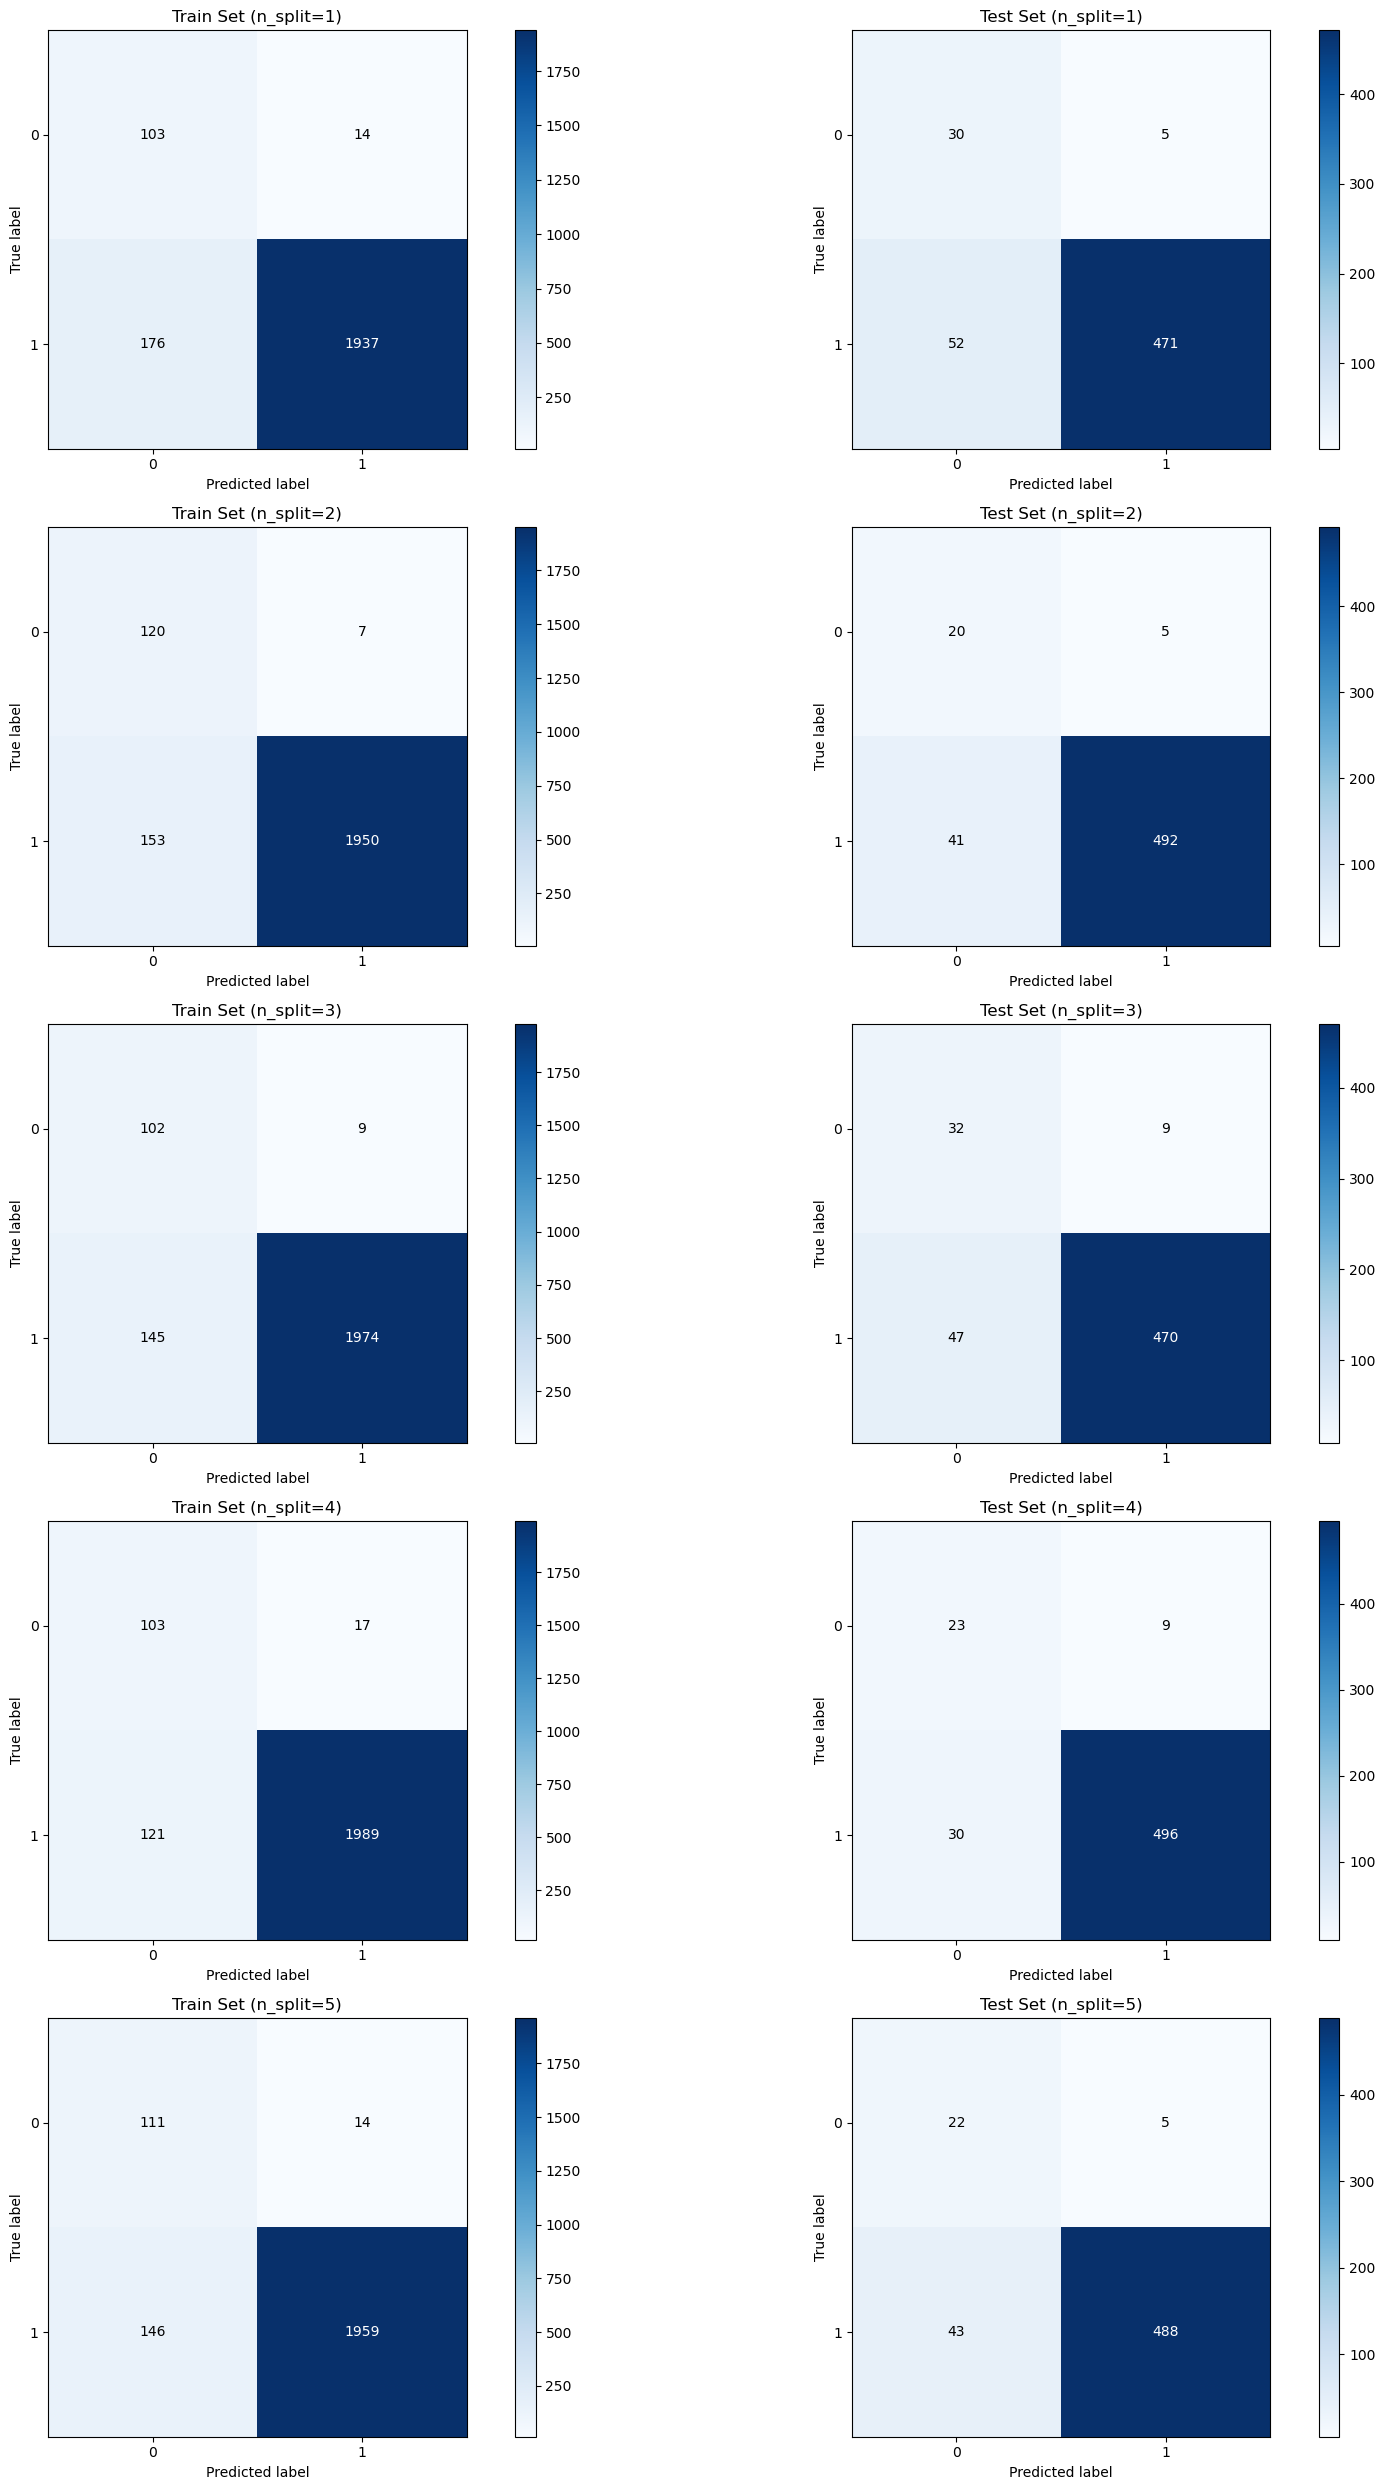

In [18]:
MyMultiTrainTester.plot_confusion(normalize=False)

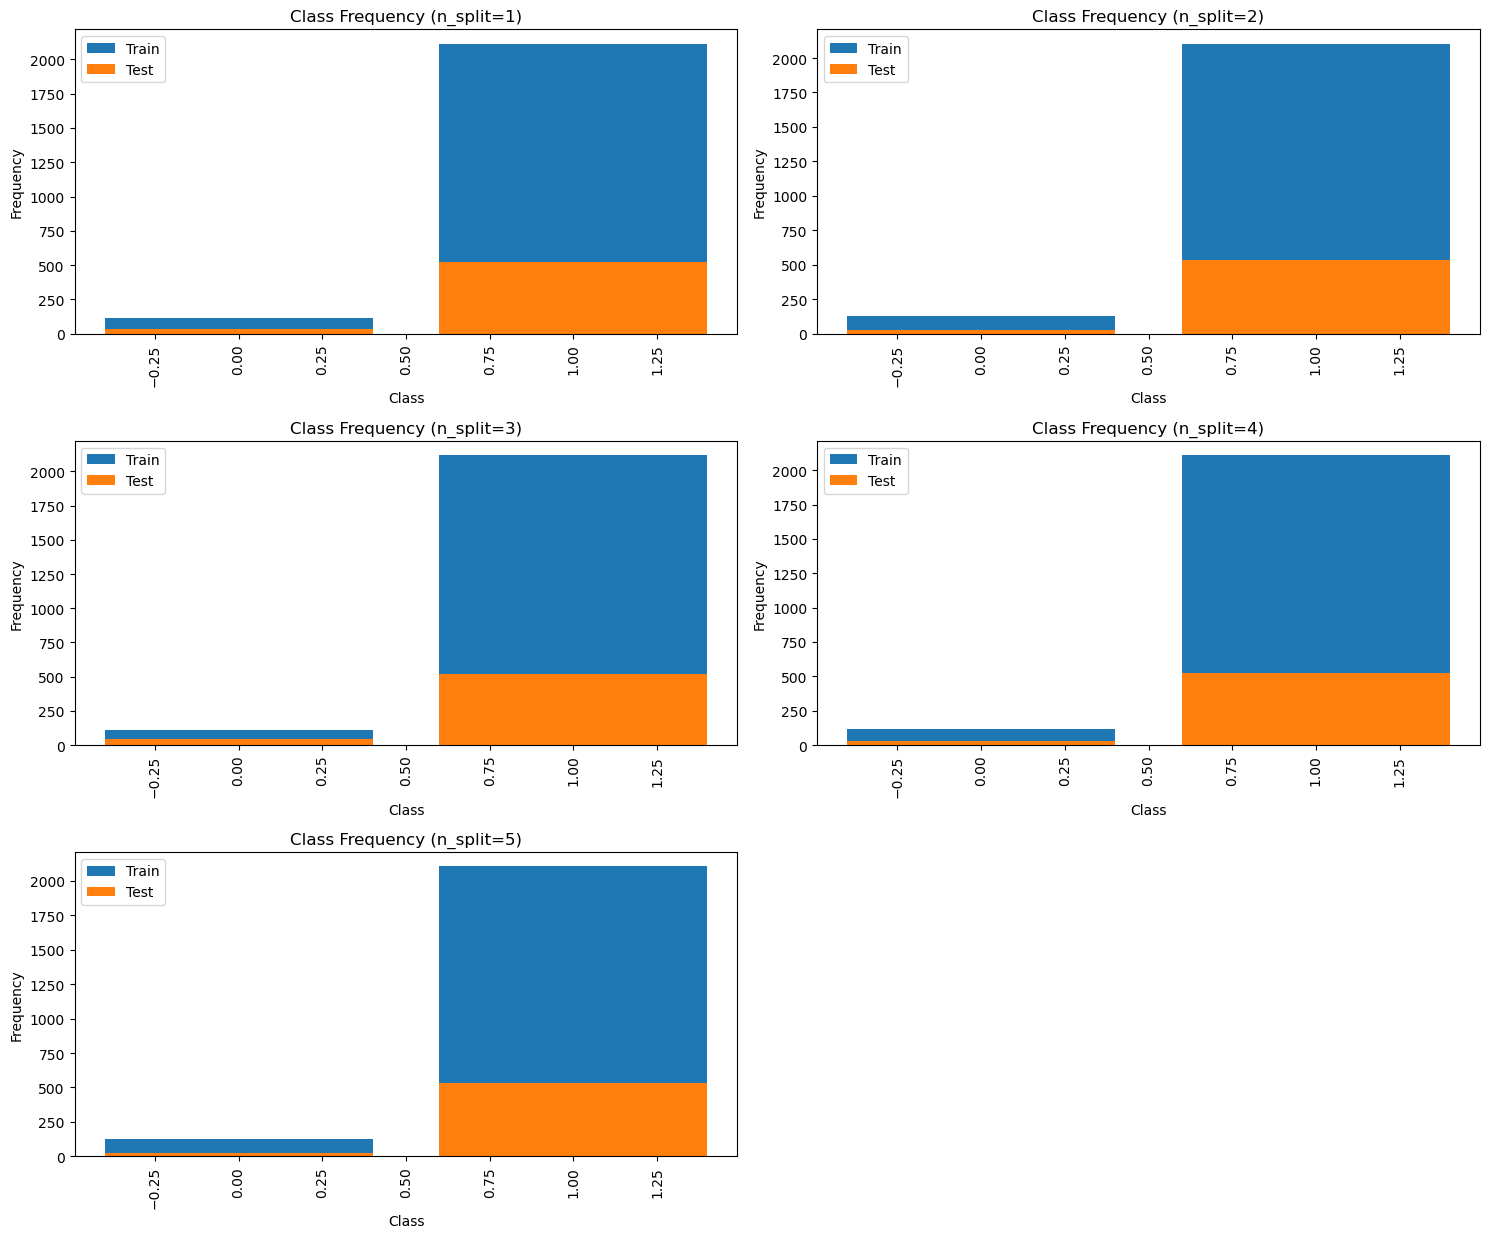

In [19]:
MyMultiTrainTester.plot_class_freq(normalize=True)

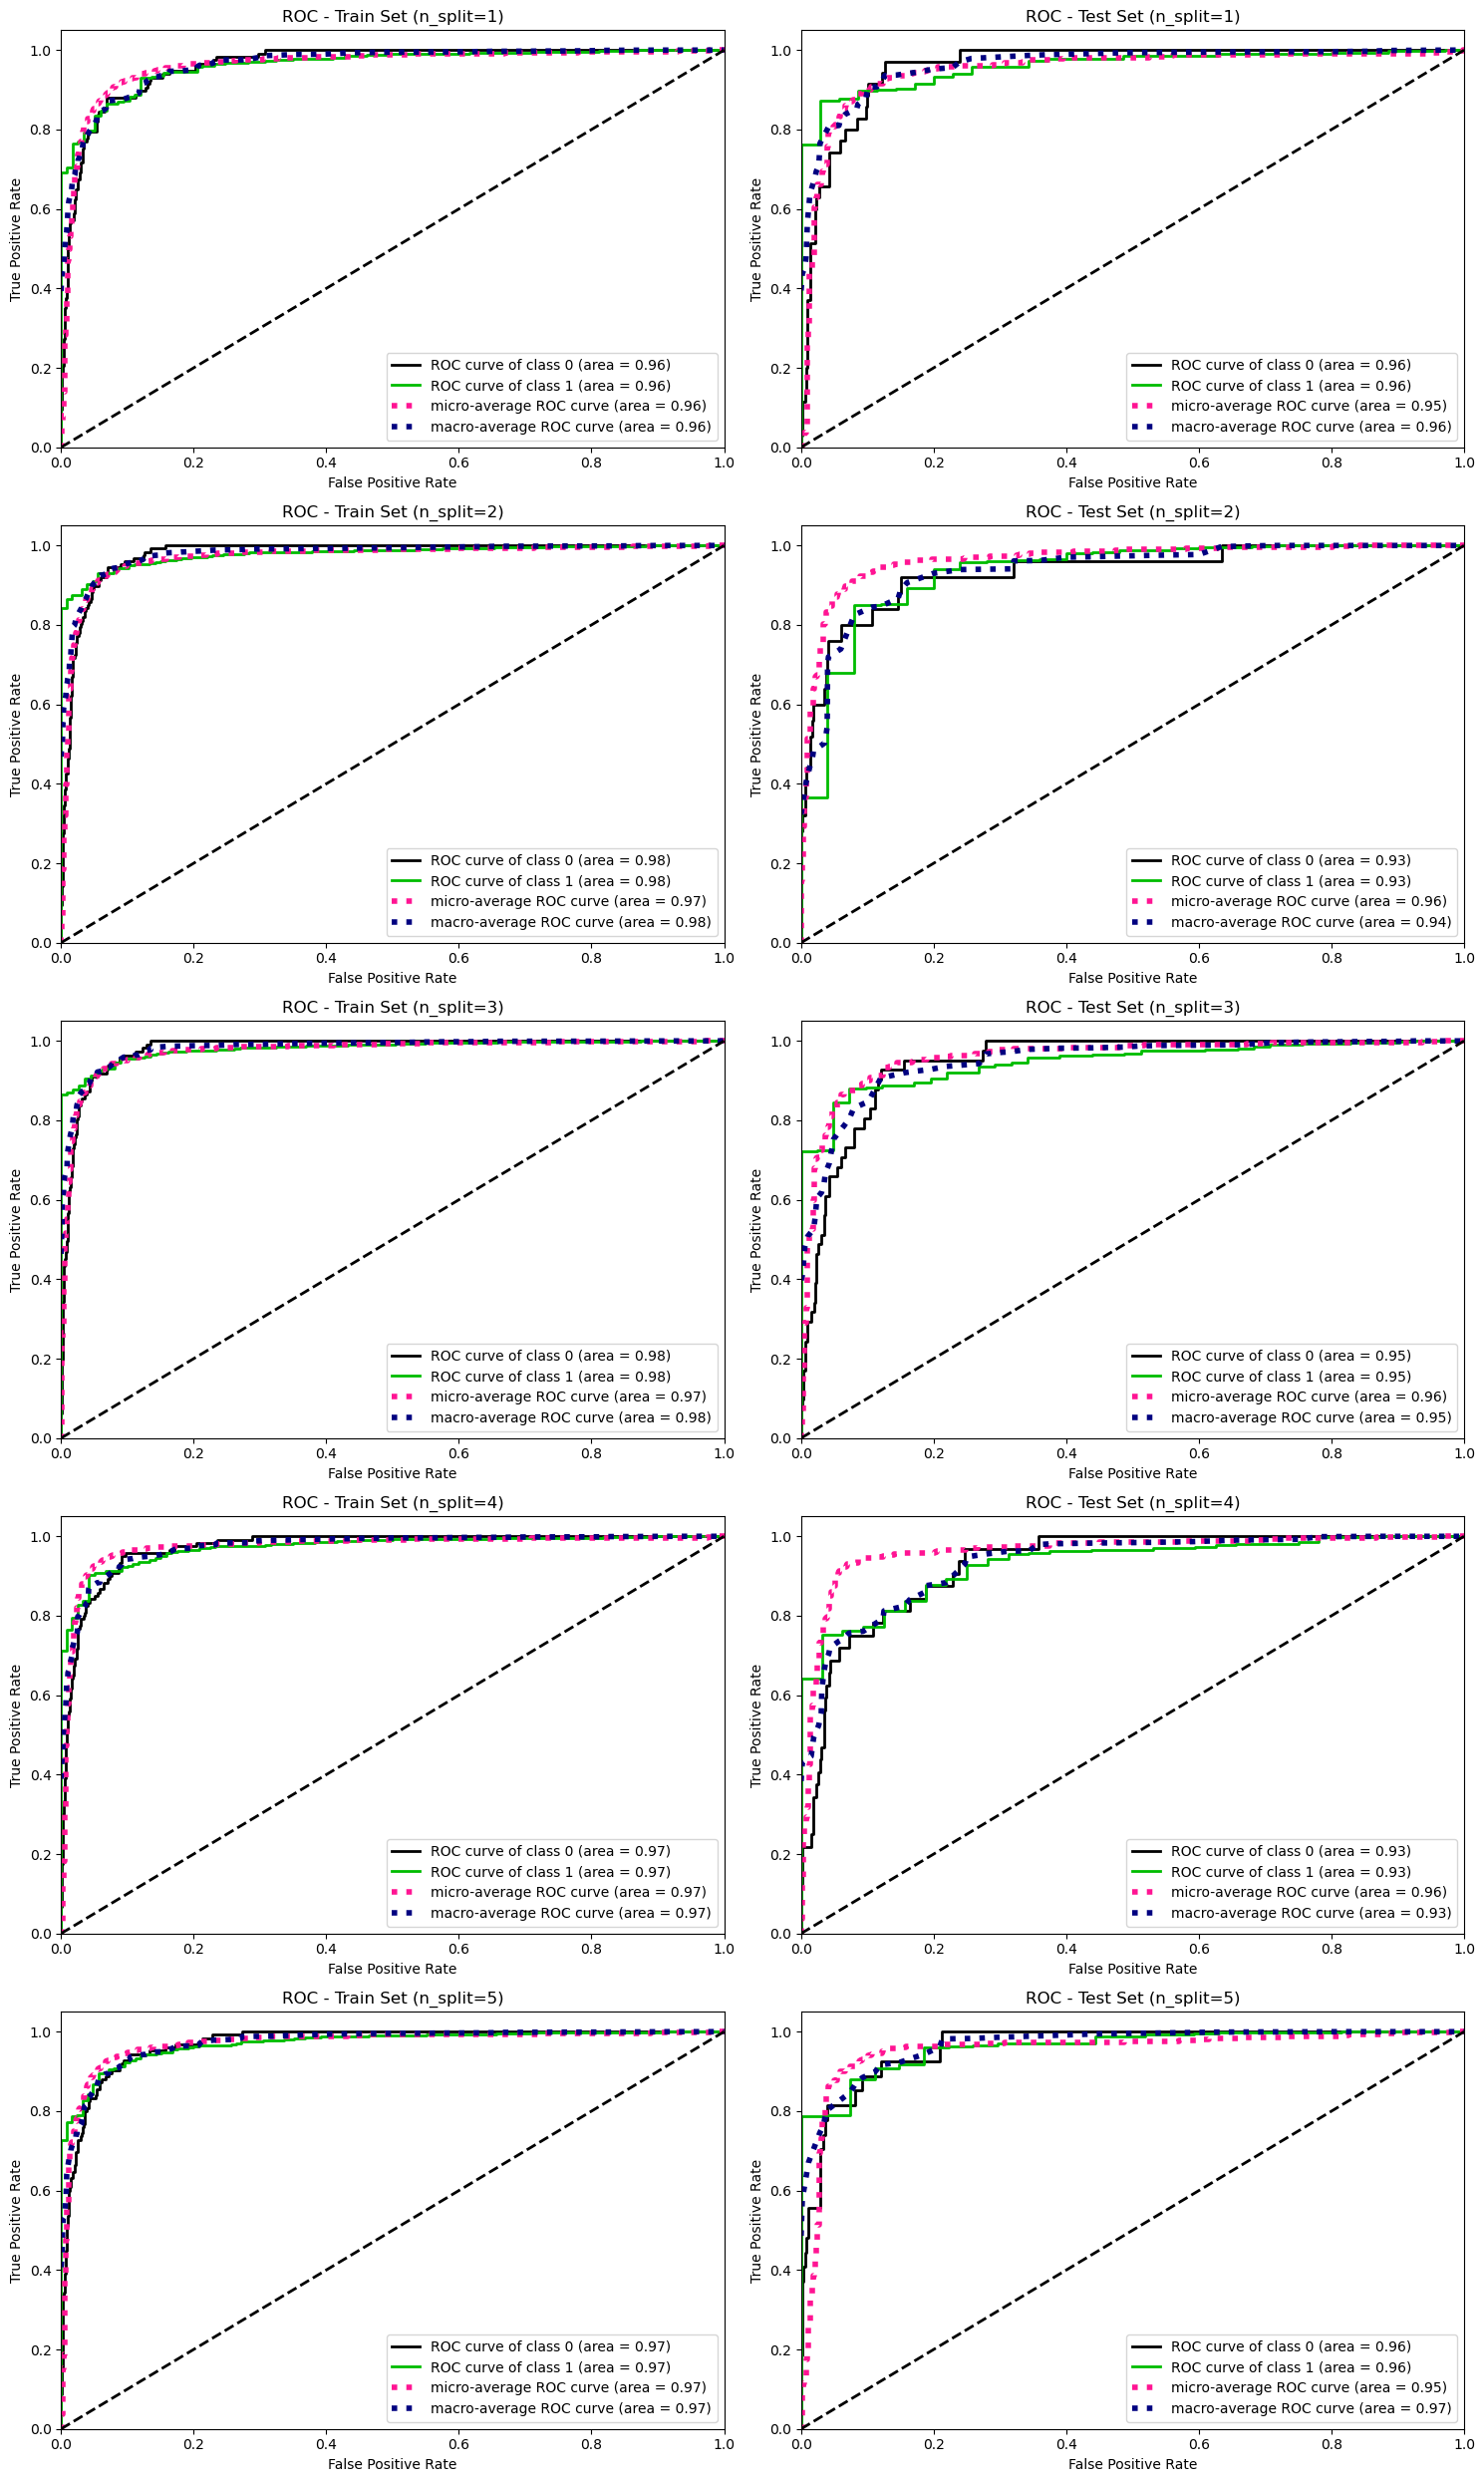

In [20]:
MyMultiTrainTester.plot_roc()

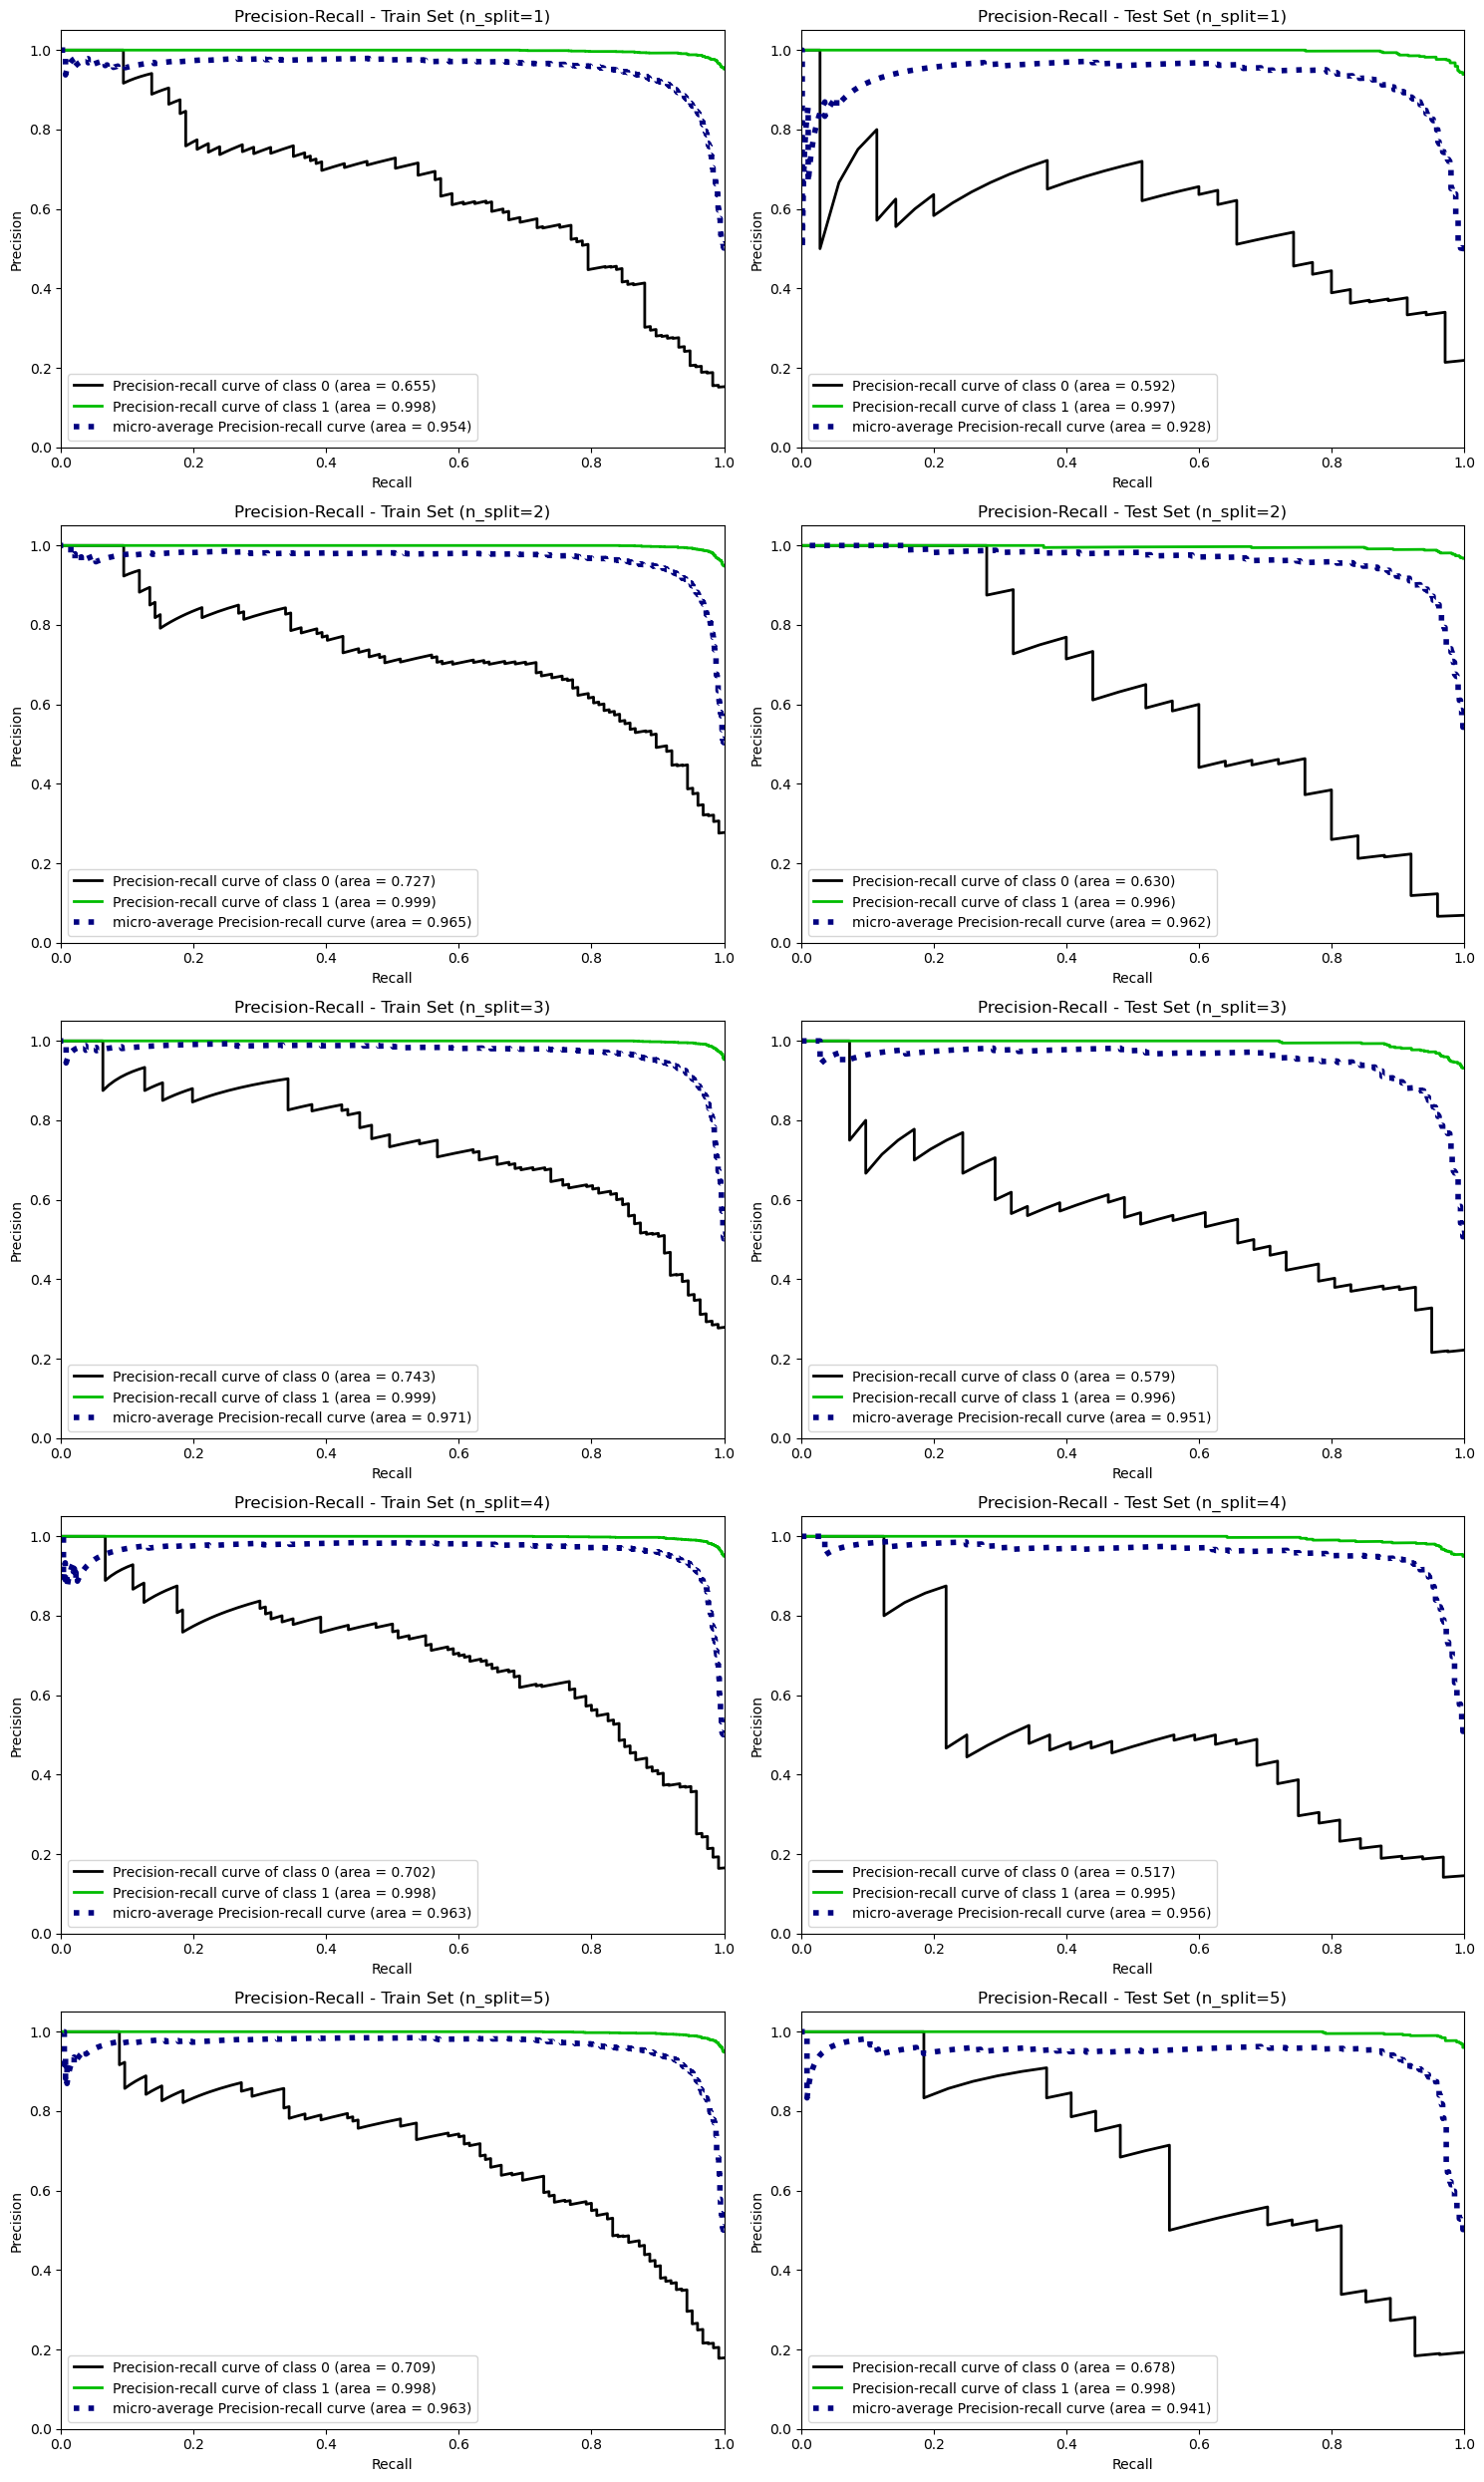

In [21]:
MyMultiTrainTester.plot_precrecall()

# Evaluate Model Performance on ACVD Study Data Only

In [22]:
FinalModel = MyMultiTrainTester.TrainerList[0]

In [23]:
train_idx0 = MyMultiTrainTester.train_idx[0]
test_idx0 = MyMultiTrainTester.test_idx[0]
SampleMetaTrain = SampleMeta.iloc[train_idx0, :]
SampleMetaTest = SampleMeta.iloc[test_idx0, :]

In [24]:
# get indices
train_idx_study = np.argwhere((SampleMetaTrain['Study Accession'] == 'PRJEB21528').to_numpy()).flatten()
test_idx_study = np.argwhere((SampleMetaTest['Study Accession'] == 'PRJEB21528').to_numpy()).flatten()

In [25]:
# check metadata
SampleMetaTrain.iloc[train_idx_study, :]['Gender'].value_counts()

M    111
F     68
Name: Gender, dtype: int64

In [26]:
SampleMetaTest.iloc[test_idx_study, :]['Gender'].value_counts()

M    34
F    14
Name: Gender, dtype: int64

In [27]:
np.sum(SampleMetaTrain.iloc[train_idx_study, :]['BMI'].to_numpy() == -99)

6

In [28]:
np.sum(SampleMetaTest.iloc[test_idx_study, :]['BMI'].to_numpy() == -99)

2

In [29]:
# Setup data for evaluation
X_train_study = X[train_idx0, :][train_idx_study, :]
y_train_study = y[train_idx0][train_idx_study]
X_test_study = X[test_idx0, :][test_idx_study, :]
y_test_study = y[test_idx0][test_idx_study]

## Train

In [30]:
FinalModel.score(X_train_study, y_train_study, RECALL_SCORE)

0.7024566984800282

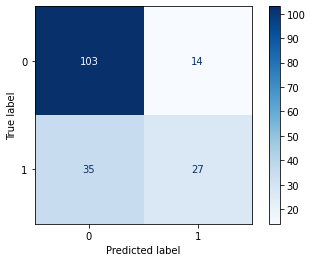

In [31]:
X_train_study_transf = FinalModel.transform_X(X_train_study)
metrics.plot_confusion_matrix(FinalModel.model, X_train_study_transf, y_train_study, cmap=plt.cm.Blues)

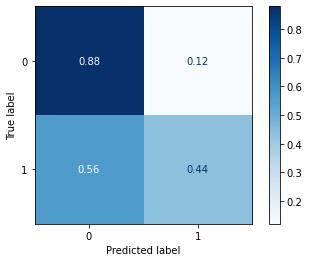

In [32]:
metrics.plot_confusion_matrix(FinalModel.model, X_train_study_transf, y_train_study, cmap=plt.cm.Blues, normalize='true')

## Test

In [33]:
FinalModel.score(X_test_study, y_test_study, RECALL_SCORE)

0.7626050420168067

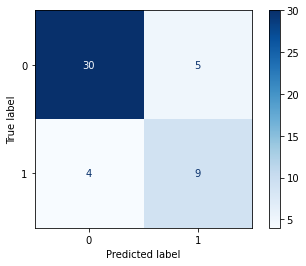

In [34]:
X_test_study_transf = FinalModel.transform_X(X_test_study)
metrics.plot_confusion_matrix(FinalModel.model, X_test_study_transf, y_test_study, cmap=plt.cm.Blues)

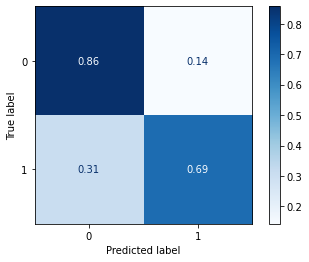

In [35]:
metrics.plot_confusion_matrix(FinalModel.model, X_test_study_transf, y_test_study, cmap=plt.cm.Blues, normalize='true')

# Assess if Decision Boundary Fit to Distinguish Jie Samples from Rest

In [36]:

# del SampleMetaTrain
# del SampleMetaTest

def get_healthies_i(X, MultiTrainTester, SampleMeta, i):
    model_i = MultiTrainTester.TrainerList[i]
    train_idx = MultiTrainTester.train_idx[i]
    test_idx = MultiTrainTester.test_idx[i]
    SampleMetaTrain = SampleMeta.iloc[train_idx, :]
    SampleMetaTest = SampleMeta.iloc[test_idx, :]
    healthy_train_idx = (SampleMetaTrain['Phenotype'] == 'Healthy').to_numpy()
    healthy_test_idx = (SampleMetaTest['Phenotype'] == 'Healthy').to_numpy()
    # Note that among healthies, we're assessing if classifier predicts healthy as NOT from Jie 2017 study
    X_train_healthy = X[train_idx, :][healthy_train_idx, :]
    y_train_healthy = (SampleMetaTrain.iloc[healthy_train_idx, :]['Study Accession'].to_numpy() != 'PRJEB21528').astype('int64')
    y_train_healthy_pred = model_i.predict(X_train_healthy)
    X_test_healthy = X[test_idx, :][healthy_test_idx, :]
    y_test_healthy = (SampleMetaTest.iloc[healthy_test_idx, :]['Study Accession'].to_numpy() != 'PRJEB21528').astype('int64')
    y_test_healthy_pred = model_i.predict(X_test_healthy)
    
    return model_i, X_train_healthy, y_train_healthy, X_test_healthy,  y_test_healthy 

def plot_confusion_healthies(X, MultiTrainTester, SampleMeta, n_splits, **args):
    
    fig0 = plt.figure(num=None, figsize=(18,25))
    m = 1
    for i in range(n_splits):
        
        model_i, X_train_healthy,  y_train_healthy, X_test_healthy,  y_test_healthy = get_healthies_i(X, MultiTrainTester, SampleMeta, i) 
        y_train_healthy_pred = model_i.predict(X_train_healthy)
        y_test_healthy_pred = model_i.predict(X_test_healthy)
        skpm.plot_confusion_matrix(y_pred=y_train_healthy_pred, y_true=y_train_healthy, cmap=plt.cm.Blues,
                                     title=f"Train Set (n_split={i+1})", ax = fig0.add_subplot(n_splits, 2, m),
                                  **args)
        m += 1
        skpm.plot_confusion_matrix(y_pred=y_test_healthy_pred, y_true=y_test_healthy, cmap=plt.cm.Blues,
                                     title=f"Test Set (n_split={i+1})", ax = fig0.add_subplot(n_splits, 2, m),
                                  **args)
        m += 1
        
def plot_roc_healthies(X, MultiTrainTester, SampleMeta, n_splits, **args):

    fig = plt.figure(num=None, figsize=(18,25))
    m = 1
    for i in range(n_splits):
        model_i, X_train_healthy,  y_train_healthy, X_test_healthy,  y_test_healthy = get_healthies_i(X, MultiTrainTester, SampleMeta, i)
        y_train_pred_proba = model_i.predict_proba(X_train_healthy)
        y_test_pred_proba = model_i.predict_proba(X_test_healthy)
        skpm.plot_roc(y_true=y_train_healthy, 
                      y_probas=y_train_pred_proba, title=f"ROC - Train Set (n_split={i+1})", ax=fig.add_subplot(n_splits,2,m), **args)
        m+=1
        skpm.plot_roc(y_true=y_test_healthy, 
                      y_probas=y_test_pred_proba, title=f"ROC - Test Set (n_split={i+1})", ax=fig.add_subplot(n_splits,2,m), **args)
        m+=1
        
def plot_prc_healthies(X, MultiTrainTester, SampleMeta, n_splits, **args):

    fig = plt.figure(num=None, figsize=(18,25))
    m = 1
    for i in range(n_splits):
        model_i, X_train_healthy,  y_train_healthy, X_test_healthy,  y_test_healthy = get_healthies_i(X, MultiTrainTester, SampleMeta, i)
        y_train_pred_proba = model_i.predict_proba(X_train_healthy)
        y_test_pred_proba = model_i.predict_proba(X_test_healthy)
        skpm.plot_precision_recall(y_true=y_train_healthy, 
                      y_probas=y_train_pred_proba, title=f"Precision/Recall - Train Set (n_split={i+1})", ax=fig.add_subplot(n_splits,2,m), **args)
        m+=1
        skpm.plot_precision_recall(y_true=y_test_healthy, 
                      y_probas=y_test_pred_proba, title=f"Precision/Recall - Test Set (n_split={i+1})", ax=fig.add_subplot(n_splits,2,m), **args)
        m+=1



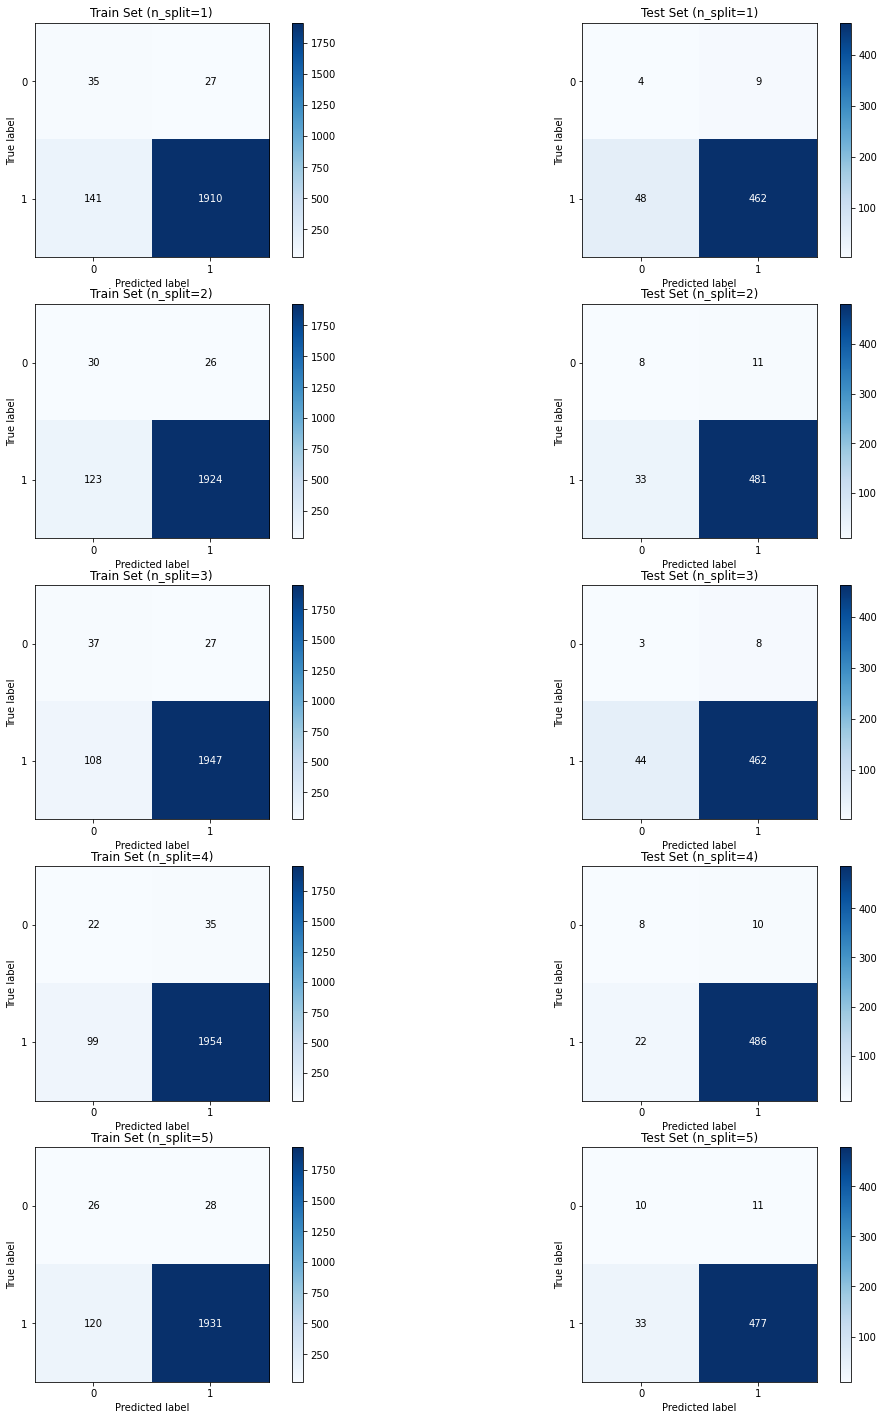

In [37]:
plot_confusion_healthies(X, MyMultiTrainTester, SampleMeta, n_splits=5, normalize=False)

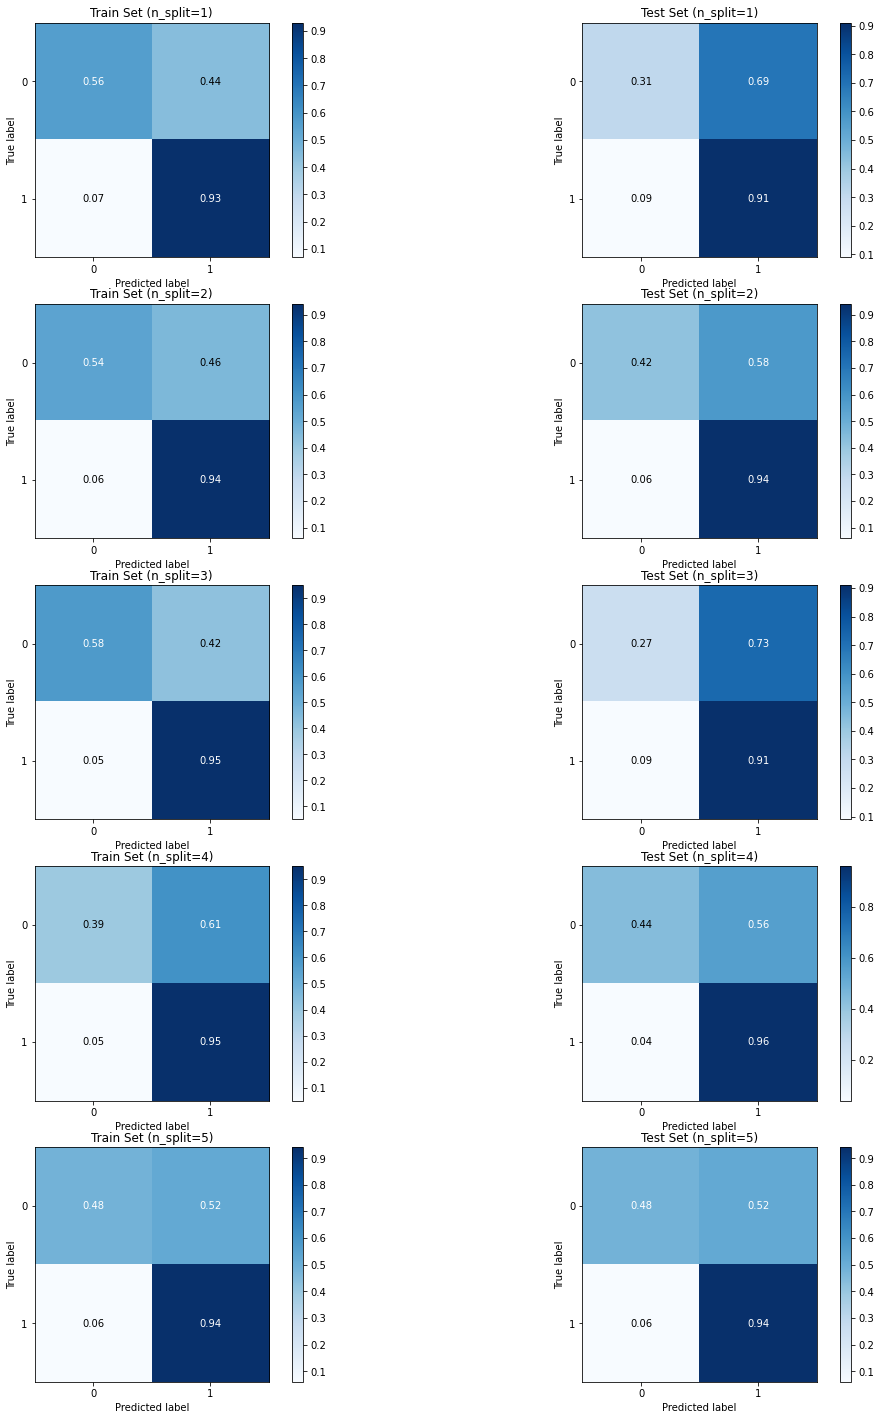

In [38]:
plot_confusion_healthies(X, MyMultiTrainTester, SampleMeta, n_splits=5, normalize=True)

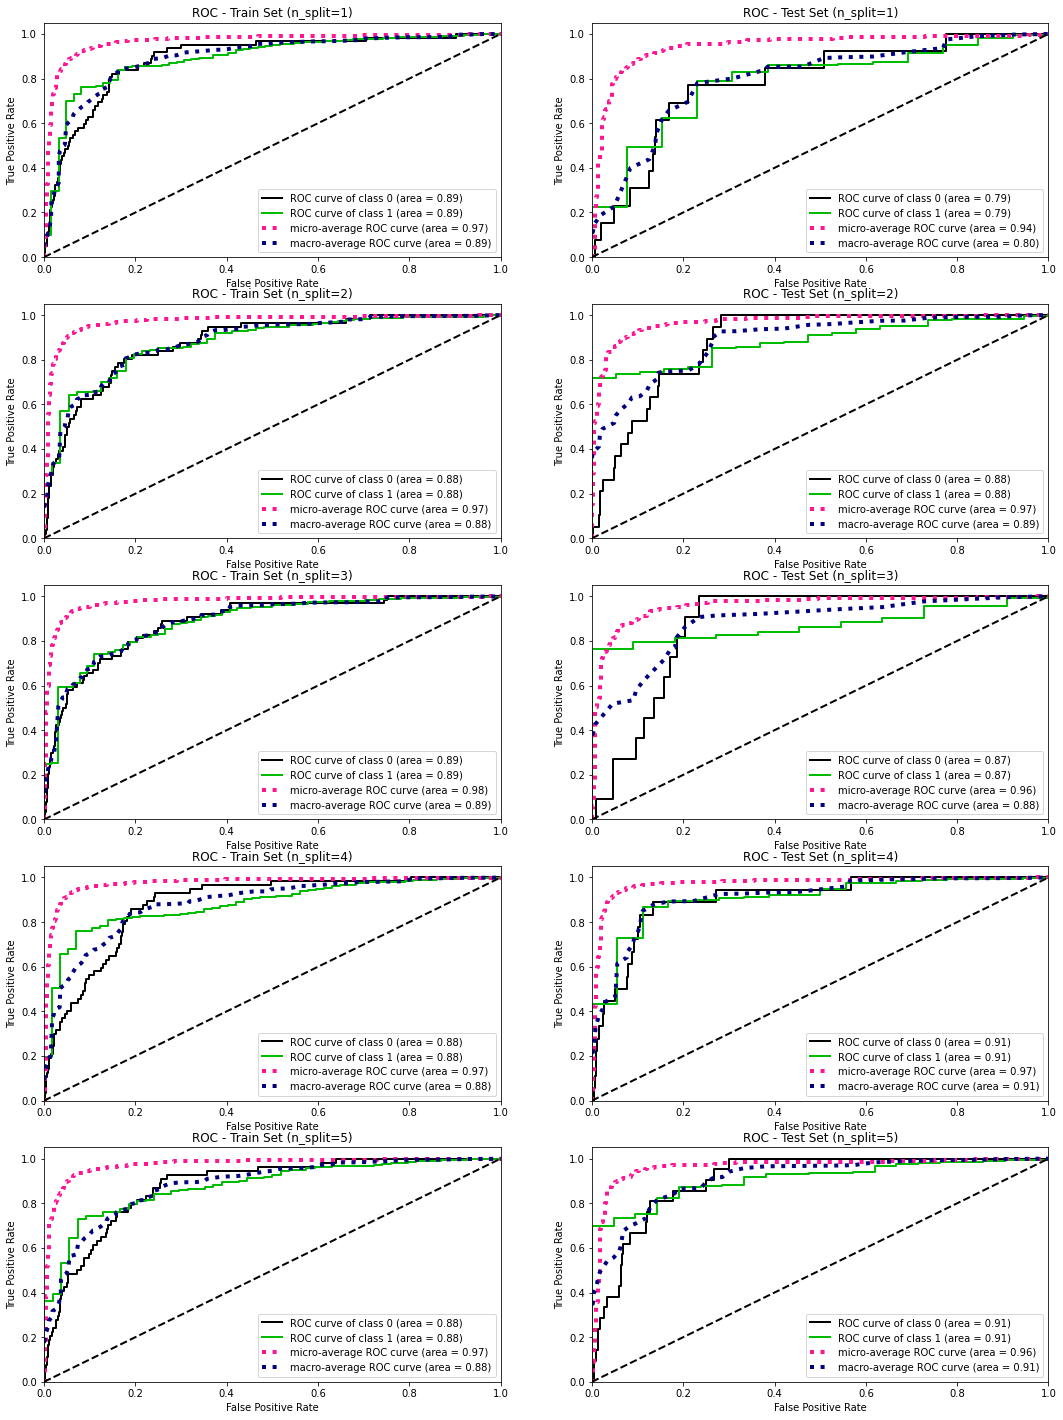

In [39]:
plot_roc_healthies(X, MyMultiTrainTester, SampleMeta, n_splits=5)

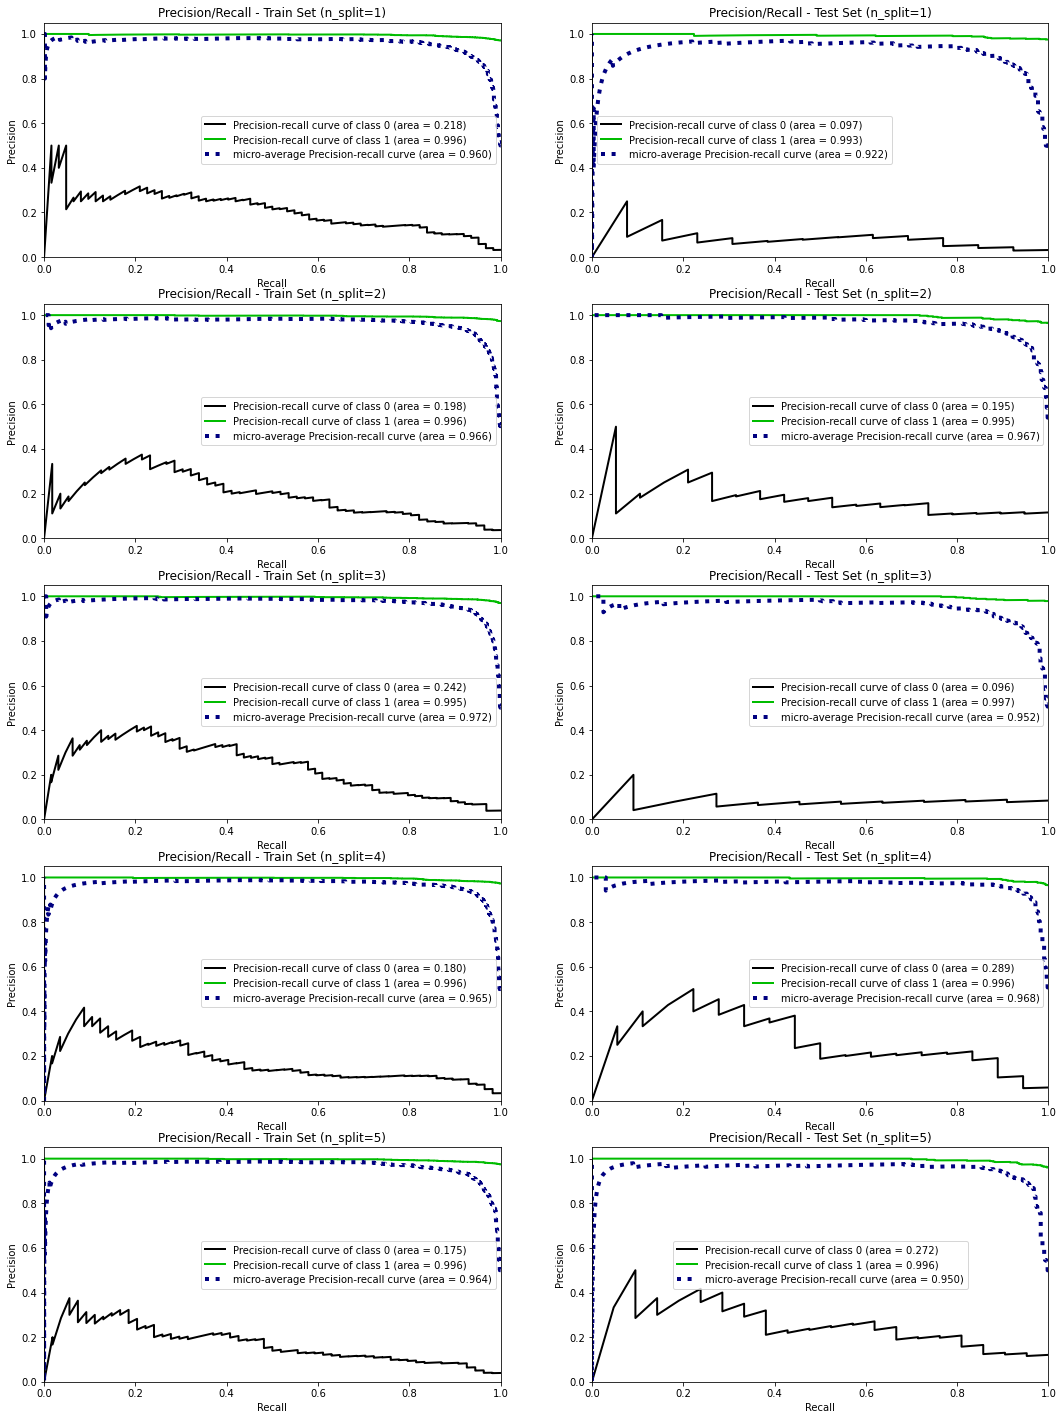

In [40]:
plot_prc_healthies(X, MyMultiTrainTester, SampleMeta, n_splits=5)

Overall, it appears that we may be picking up some signal separating ACVD from healthy, but a large portion of signal picked up by classifier is study specific effects. Our 'True' class for the confusion matrix/ROC/PRC plots is whether or not a sample is NOT from the Jie 2017 study.